In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib

In [2]:
df = pd.read_csv('train-positive-pairs.csv')
df.shape

(700282, 5)

In [3]:
# check if there are only two records linked to each link
assert df.groupby('link').count().title.map(lambda x: x == 2).all()

In [4]:
# check if records linked to aech link are from different dataser
assert df.groupby('link').source.apply(tuple).map(lambda x: x[0] != x[1]).all()

In [5]:
df['i'] = df.index
true_pairs = set(df.groupby('link').i.apply(tuple))
# true_pairs

In [6]:
# check if order of id's is valid
assert df.groupby('link').i.apply(tuple).map(lambda x: x[0] < x[1]).all()

In [7]:
sim = pd.read_csv('sim-pairs-60.csv', index_col=0)

/home/wojtek/.local/lib/python3.7/site-packages/numpy/lib/arraysetops.py:568: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [8]:
def index_pairs_from_df(dataframe):
    result = []
    for row in dataframe.itertuples(False, None):
#         print(row)
        result.append((row[0], row[1]))
        
    return result
index_pairs_from_df(sim.head())

[(32, 16584), (32, 18745), (32, 18764), (39, 10404), (39, 11522)]

In [9]:
sim.loc[sim.similarity == 1].head()

,I1,I2,similarity
7483,8461,124894,1.0
13367,3276,224721,1.0
13581,6997,225183,1.0
16501,6025,278222,1.0
20170,1791,355504,1.0


In [10]:
for pair in index_pairs_from_df(sim.loc[sim.similarity == 1].head()):
    print(pair in true_pairs, pair)

False (8461, 124894)
False (3276, 224721)
False (6997, 225183)
False (6025, 278222)
True (1791, 355504)


In [11]:
# small manual checkup
for p1, p2 in index_pairs_from_df(sim.loc[sim.similarity == 1].head()):
    print('----------------------------')
    print(df.iloc[p1])
    print(df.iloc[p2])

----------------------------
title                                     Sweet And Sour Lentils
ingredients    ["1 1/2 cups brown lentils", "2 cups unsweeten...
directions     ["Rinse the lentils. Combine them in a saucepa...
link           www.food.com/recipe/sweet-and-sour-lentils-444615
source                                                  Gathered
i                                                           8461
Name: 8461, dtype: object
title                                     Sweet And Sour Lentils
ingredients    ["1 1/2 cups brown lentils", "2 cups unsweeten...
directions     ["Rinse the lentils. Combine them in a saucepa...
link           www.food.com/recipe/sweet-and-sour-lentils-430560
source                                                  Gathered
i                                                         124894
Name: 124894, dtype: object
----------------------------
title                                Simple Seasoned Black Beans
ingredients    ["1 (16 ounce) can black bea

In [12]:
def precision(true_pairs: set, selected_pairs: set):
    return len(true_pairs.intersection(selected_pairs))/len(selected_pairs)

assert precision(set([1,2]), set([1,2,3,4,5])) == 0.4

In [13]:
def recall(true_pairs: set, selected_pairs: set):
    return len(true_pairs.intersection(selected_pairs))/len(true_pairs)

assert recall(set([1,2]), set([1,2,3,4,5])) == 1

In [14]:
def get_prec_recall_f1(true_pairs: set, selected_pairs: set):
    prec = precision(true_pairs, selected_pairs)
    rec = recall(true_pairs, selected_pairs)
    f1 = 2*prec*rec/(prec+rec)
    return (prec, rec, f1)

get_prec_recall_f1(set([1,2]), set([1,2,3,4,5]))

(0.4, 1.0, 0.5714285714285715)

In [15]:
result = []
for i in range(0, 41, 1):
    treshold = 0.6 + i*0.01
    selected = set(index_pairs_from_df(sim.loc[sim.similarity >= treshold]))
    tup = get_prec_recall_f1(true_pairs, selected)
    result.append((treshold, ) + tup)

In [16]:
result[29:36]

[(0.8899999999999999,
  0.9531922500446901,
  0.9898726513033321,
  0.9711862317094357),
 (0.8999999999999999,
  0.9579156484298372,
  0.9873993619713202,
  0.9724340736844622),
 (0.9099999999999999,
  0.9624861383068762,
  0.9840921228876367,
  0.9731692231219163),
 (0.9199999999999999,
  0.9668677925959343,
  0.9793740236076324,
  0.9730807266061398),
 (0.9299999999999999,
  0.9711378796783968,
  0.9721169471727105,
  0.9716271667844172),
 (0.94, 0.975382689649777, 0.9614041200544924, 0.9683429603718875),
 (0.95, 0.9793904553064763, 0.9439340151538952, 0.9613354159213271)]

In [17]:
# pivot the result
tre = []
pre = []
rec = []
f1 = []
for t, p, r, f in result[::2]:
    tre.append(t)
    pre.append(p)
    rec.append(r)
    f1.append(f)

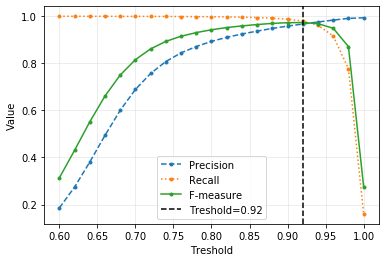

In [18]:
fig, ax = plt.subplots()

pre_line = ax.plot(tre, pre, label='Precision', linestyle='dashed', marker='.')
rec_line = ax.plot(tre, rec, label='Recall', linestyle='dotted', marker='.')
f1_line = ax.plot(tre, f1, label="F-measure", linestyle='solid', marker='.')

ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
ax.xaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)

ax.set_ylabel('Value')
ax.set_xlabel('Treshold')

plt.axvline(x=0.92, color='k', linestyle='--', label='Treshold=0.92')

ax.legend()
plt.savefig('hyperparam-cosine-sim-treshold.png', dpi=600)
tikzplotlib.save('hyperparam-cosine-sim-treshold.tex')
plt.show()